❓So Why Is the Model Still Missing Overload Cases?
Here’s why:

1. ⏱️ You’re training on chronological sequences, but overloads aren’t always gradual — they can be sudden ZIP bursts
2. 🔁 ZIPs are mixed across chutes over time — but LSTM is seeing one stream
3. 🧠 The model might not be attending to CHUTE_LOAD enough
4. ⚖️ Imbalance is still skewing model toward "no issue"
✅ What You Can Do (Now That You Have CHUTE_LOAD):
✅ 1. Highlight spikes with a chute_load_diff feature
✅ 2. Add ZIP_COUNT_TO_CHUTE (number of ZIPs targeting a chute)


Epoch 01: Loss=1.1522 | MAE=2.16 | Acc=73.34% | Precision=9.81% | Recall=61.62% | F1=16.92%
Epoch 02: Loss=1.1189 | MAE=2.02 | Acc=66.52% | Precision=8.84% | Recall=70.87% | F1=15.72%
Epoch 03: Loss=1.1070 | MAE=2.04 | Acc=68.70% | Precision=9.33% | Recall=70.00% | F1=16.47%
Epoch 04: Loss=1.0976 | MAE=1.96 | Acc=69.79% | Precision=9.70% | Recall=70.45% | F1=17.05%
Epoch 05: Loss=1.0836 | MAE=2.02 | Acc=68.64% | Precision=9.41% | Recall=70.95% | F1=16.62%
Epoch 06: Loss=1.0784 | MAE=2.13 | Acc=67.98% | Precision=9.34% | Recall=71.93% | F1=16.53%
Epoch 07: Loss=1.0781 | MAE=2.08 | Acc=73.92% | Precision=10.62% | Recall=66.35% | F1=18.31%
Epoch 08: Loss=1.0612 | MAE=2.12 | Acc=70.28% | Precision=10.02% | Recall=71.95% | F1=17.59%
Epoch 09: Loss=1.0645 | MAE=2.01 | Acc=71.72% | Precision=10.31% | Recall=70.39% | F1=17.99%
Epoch 10: Loss=1.0518 | MAE=2.08 | Acc=68.66% | Precision=9.75% | Recall=74.02% | F1=17.23%
Epoch 11: Loss=1.0601 | MAE=2.19 | Acc=69.96% | Precision=9.98% | Recall=72.4

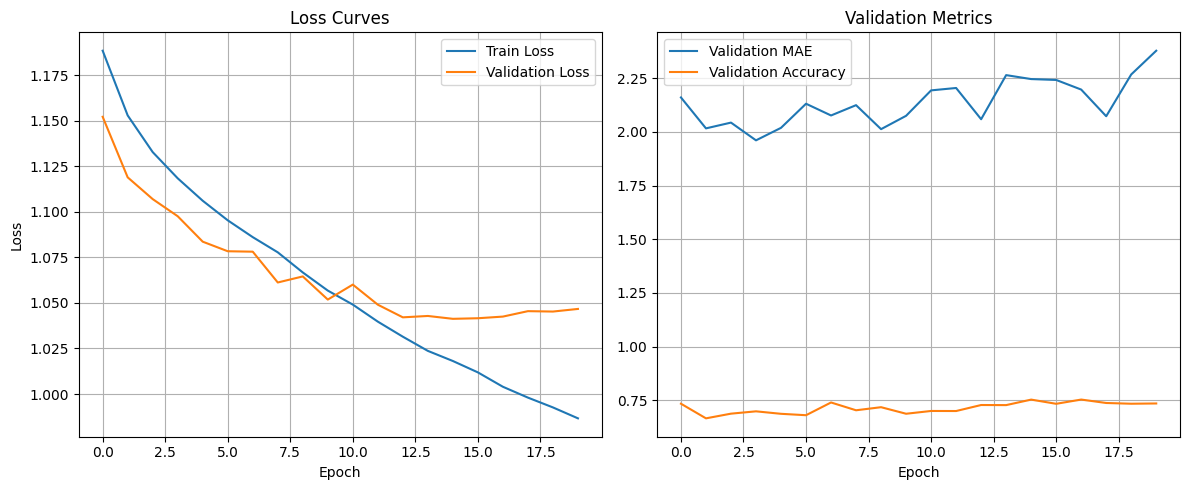

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# 1. Load and prepare data
df = pd.read_csv("../DATA/data5day_new.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])

# Encode categorical fields
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# Add feature: number of ZIPs sending to the chute at each hour
df['zip_count_to_chute'] = df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

# Define features and targets
features = [
    'CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
    'CHUTE_LOAD', 'ZIP_PACKAGE_COUNT', 'HOUR_OF_DAY', 'DAY_OF_WEEK',
    'zip_count_to_chute'  # newly added feature
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'PERFORMANCE_ISSUE'

# Normalize features and regression target
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])
target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# Create sequences
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# Create datasets and loaders
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# Define LSTM model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)  # No sigmoid

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.fc_cls(out)

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()

# Weighted loss for class imbalance
issue_counts = df['PERFORMANCE_ISSUE'].value_counts()
pos_weight = torch.tensor([issue_counts[0] / issue_counts[1]])
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses, val_losses = [], []
val_mae_scores, val_acc_scores = [], []
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    train_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls_logits = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls_logits.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    y_reg_preds, y_cls_preds = [], []
    y_reg_true, y_cls_true = [], []

    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls_logits = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls_logits.view(-1), yb_cls)
            val_loss += loss.item()

            y_reg_preds.extend(out_reg.view(-1).numpy())
            y_cls_preds.extend(torch.sigmoid(out_cls_logits.view(-1)).numpy())
            y_reg_true.extend(yb_reg.numpy())
            y_cls_true.extend(yb_cls.numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_mae = mean_absolute_error(
        target_scaler.inverse_transform(np.array(y_reg_true).reshape(-1, 1)),
        target_scaler.inverse_transform(np.array(y_reg_preds).reshape(-1, 1))
    )
    val_acc = accuracy_score(y_cls_true, np.array(y_cls_preds) > 0.5)
    val_precision = precision_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_recall = recall_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_f1 = f1_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)

    val_mae_scores.append(val_mae)
    val_acc_scores.append(val_acc)

    print(f"Epoch {epoch+1:02}: Loss={val_loss:.4f} | MAE={val_mae:.2f} | "
          f"Acc={val_acc:.2%} | Precision={val_precision:.2%} | Recall={val_recall:.2%} | F1={val_f1:.2%}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Save best model
torch.save(best_model_state, "best_lstm_hybridv5.pt")
print("✅ Best model saved.")

# Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_mae_scores, label="Validation MAE")
plt.plot(val_acc_scores, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.title("Validation Metrics")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [7]:
def predict_and_compare_at_time(df_raw, target_time, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df = df_raw[df_raw['HOUR_TIME'] <= pd.to_datetime(target_time)]
    df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    results = []

    for chute in df['CHUTE'].unique():
        chute_df = df[df['CHUTE'] == chute].copy()
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue

        seq_df = chute_df.iloc[-seq_len:].copy()

        # Encode categorical features as in training
        seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
        seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes

        # Recreate missing engineered feature
        if 'zip_count_to_chute' not in seq_df.columns:
            seq_df['zip_count_to_chute'] = seq_df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

        # Scale features
        seq_df[features] = feature_scaler.transform(seq_df[features])

        # Prepare input tensor
        x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

        with torch.no_grad():
            y_pred_reg, y_pred_cls_logits = model(x_seq)

            # Apply sigmoid manually
            prob = torch.sigmoid(y_pred_cls_logits.view(-1)).item()
            pred_issue = int(prob > 0.5)

            pred_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]

        latest = chute_df.iloc[-1]
        actual_time = latest['AVG_PROCESSING_TIME_MINUTES']
        actual_issue = latest['PERFORMANCE_ISSUE']
        zip_code = latest['ZIP_CODE']
        hour = latest['HOUR_TIME']

        results.append({
            'Time': hour,
            'CHUTE': chute,
            'ZIP_CODE': zip_code,
            'Actual_Processing_Time': actual_time,
            'Predicted_Processing_Time': pred_time,
            'Actual_Performance_Issue': actual_issue,
            'Predicted_Performance_Issue': pred_issue,
            'Predicted_Issue_Probability': prob
        })

    return pd.DataFrame(results)


In [8]:
df = pd.read_csv("./DATA/data5day_new.csv")

compare_df = predict_and_compare_at_time(
    df_raw=df,
    target_time="2025-03-24 15:00",  # Pick any timestamp you like
    model=model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_len=5
)

print(compare_df)


C:\Users\moata\AppData\Local\Temp\ipykernel_32304\3053477384.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)


                   Time  CHUTE  ZIP_CODE  Actual_Processing_Time  \
0   2025-03-24 15:00:00  R0101    848400                1.633333   
1   2025-03-24 15:00:00  R0102    949800                1.483333   
2   2025-03-24 15:00:00  R0103    659400                1.416667   
3   2025-03-24 15:00:00  R0104    803700                2.875000   
4   2025-03-24 15:00:00  R0105    707500                1.116667   
..                  ...    ...       ...                     ...   
355 2025-03-22 00:00:00  R3527    318200                3.633333   
356 2025-03-22 00:00:00  R3528    375800                3.366667   
357 2025-03-24 15:00:00  R5101    100025                2.125000   
358 2025-03-24 15:00:00  R5102    601700                7.383333   
359 2025-03-24 15:00:00  R5103    176300                1.350000   

     Predicted_Processing_Time  Actual_Performance_Issue  \
0                     2.995663                         0   
1                     2.027008                         0   
2  

In [4]:
print(df['HOUR_TIME'].min(), df['HOUR_TIME'].max())


2025-03-24 06:00:00 2025-03-24 16:00:00


In [9]:
def scan_and_predict_issues(df_raw, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df_raw = df_raw.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    results = []
    issue_points = df_raw[df_raw['PERFORMANCE_ISSUE'] == 1]

    for idx, row in issue_points.iterrows():
        chute = row['CHUTE']
        time = row['HOUR_TIME']

        chute_df = df_raw[(df_raw['CHUTE'] == chute) & (df_raw['HOUR_TIME'] <= time)]
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue

        seq_df = chute_df.iloc[-seq_len:].copy()

        # Encode categorical features
        seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
        seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes

        # Recreate missing engineered feature
        if 'zip_count_to_chute' not in seq_df.columns:
            seq_df['zip_count_to_chute'] = seq_df.groupby(['CHUTE', 'HOUR_TIME'])['ZIP_CODE'].transform('nunique')

        # Scale features
        seq_df[features] = feature_scaler.transform(seq_df[features])

        # Prepare input tensor
        x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)

        with torch.no_grad():
            y_pred_reg, y_pred_cls_logits = model(x_seq)

            # Apply sigmoid manually to classification output
            prob = torch.sigmoid(y_pred_cls_logits.view(-1)).item()
            pred_issue = int(prob > 0.5)

            pred_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]

        results.append({
            'HOUR_TIME': time,
            'CHUTE': chute,
            'ZIP_CODE': row['ZIP_CODE'],
            'Actual_Processing_Time': row['AVG_PROCESSING_TIME_MINUTES'],
            'Predicted_Processing_Time': pred_time,
            'Actual_Performance_Issue': row['PERFORMANCE_ISSUE'],
            'Predicted_Performance_Issue': pred_issue,
            'Predicted_Issue_Probability': prob
        })

    return pd.DataFrame(results)


In [10]:
df = pd.read_csv("./DATA/data5day_new.csv")

issue_preds = scan_and_predict_issues(
    df_raw=df,
    model=model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_len=5
)

print(issue_preds.head())


            HOUR_TIME  CHUTE  ZIP_CODE  Actual_Processing_Time  \
0 2025-03-24 09:00:00  R0101    100026               13.383333   
1 2025-03-24 11:00:00  R0101    100802               11.516667   
2 2025-03-20 10:00:00  R0101    101000               12.500000   
3 2025-03-21 16:00:00  R0101    102000               23.076667   
4 2025-03-20 21:00:00  R0101    102400               10.541667   

   Predicted_Processing_Time  Actual_Performance_Issue  \
0                   2.854321                         1   
1                   3.010109                         1   
2                   3.222461                         1   
3                   3.201041                         1   
4                   1.512927                         1   

   Predicted_Performance_Issue  Predicted_Issue_Probability  
0                            1                     0.558603  
1                            0                     0.231090  
2                            0                     0.293411  
3     